# Steam Miner

Steam, the world-largest PC game distribution platform, has a huge body of customers. Powered by a freely Web API provided by Steam, we’d like to dig and reveal some interesting facts from the Steam community.

In this project, we collect data from the steam p

In [1]:
# Load matplotlib library
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [35]:
# Other packages
import operator
import numpy as np
import requests
import json
from collections import deque
import random
import time
import pickle
import igraph as ig
import math
import random
import plotly.plotly as py
import plotly
from plotly.graph_objs import *

# Analyze game playing data

In this section, we will introduce what we did to analyze the game playing history data for steam users. In brief, we collect user data on steam, then we inspect the data and did some visualization. Finally, we are able to draw some conclusion from the data we scraped.

## Collection public game playing history

At first, we try to collect data about steam users and the games they played. We start from one steam user and then scrape data of all the friends of this user, and goes on. In this way, we can collect lots of steam user's profile.

However, while doing this project, steam updated its privacy policy that each user's game playing history become friend-view-only in default which we did not expect. So we can only get the game playing history of users who set their profiles to be public. We scraped around 90,000+ user and managed to collect 3431 public profiles.

The following code snippet is used to scrap users' recently played games (two weeks), and the maximum number of game to return by the API is set to 10. The response of these APIs are in JSON format, and we store the response in files "game_part_id.json". Each file stores a maximum of 500 response and uses id to distinguish different files. We write a robust routin (ignored in this notebook for simplicity) to collect users' steam id and then using the following functions to scrape all public user gaming history.

In [3]:
class GameCrawler:
    '''
    Class that encapsulate the functions to collect data for each steam user.
    '''
    def __init__(self, count=0):
        self.api = 'http://api.steampowered.com/IPlayerService/GetRecentlyPlayedGames/v1'

        self.output = {'games': []}
        self.output_limit = 500
        self.output_file_prefix = 'user_game/games_part_'
        self.part_count = count
    
    def get_recently_played_game(self, steamid, key, count):
        '''
        Given the steam id, get the user's recently palyed games if it's public
        '''
        payload = {'steamid': steamid, 'key': key, 'count': count}
        response = requests.get(self.api, params=payload)
        json_obj = json.loads(response.text)
        if json_obj.get('response') is None or json_obj.get('response').get('total_count') is None\
          or json_obj.get('response').get('total_count') == 0:
            return
        json_obj['master_steamid'] = steamid
        self.output['games'].append(json_obj)
        if len(self.output['games']) >= self.output_limit:
            file_name = self.output_file_prefix + '{}'.format(self.part_count) + '.json'
            with open(file_name, 'w') as output_f:
                json.dump(self.output, output_f)
            self.output = {'games': []}
            self.part_count += 1

    def write_to_file(self):
        '''
        Output data into the output file
        '''
        if len(self.output['games']) > 0:
            file_name = self.output_file_prefix + '{}'.format(self.part_count) + '.json'
            with open(file_name, 'w') as output_f:
                json.dump(self.output, output_f)
            self.output = {'games': []}
            self.part_count += 1

## Utility functions

The next thing we did is processing and analyzing data. To reduce duplicate code and make the code more manageable, we implemented a set of utility functions on loading data, organizing data and plotting as follow.

In [10]:
game_file_name_prefix = "user_game/games_part_"

def generate_game_mapping():
    '''
    Load all the games json files, and write mapping from
    steam id to synthetic id starting from 0, for the purpose
    of orgnizing the data.
    Serialize the dictionary data structure in a pickle file
    '''
    record = set()
    mapping = dict()
    counter = 0
    id_file_name = 'game_id_mapping.pkl'
    part_id = 7
    for i in range(part_id + 1):
        file_name = game_file_name_prefix + '{}'.format(i) + '.json'
        with open(file_name, 'r') as input_f:
            tmp_obj = json.load(input_f)
            parent_list = tmp_obj['games']
            for response in parent_list:
                # Assign id to this steam user if it isn't appear previously
                steam_id = response['master_steamid']
                if steam_id not in record:
                    record.add(steam_id)
                    mapping[steam_id] = counter
                    counter += 1
    # Seralize mapping dict
    with open(id_file_name, 'wb') as output_f:
        pickle.dump(mapping, output_f)

def read_mapping(mapping_file_name):
    '''
    Load the steam id mapping
    '''
    with open(mapping_file_name, 'rb') as input_f:
        mapping = pickle.load(input_f)
    return mapping

def get_user_game_count():
    '''
    Find the number of recently played games for each user.
    A list is returned.
    '''
    part_id = 7
    games_list = list()
    for i in range(part_id + 1):
        # Read in a response file and count the number of recently palyed games for each uesr
        file_name = game_file_name_prefix + '{}'.format(i) + '.json'
        with open(file_name) as input_f:
            tmp_obj = json.load(input_f)
        parent_list = tmp_obj['games']
        for response in parent_list:
            inner_response = response.get('response')
            if inner_response is None:
                continue
            games = inner_response.get('games')
            if games is None:
                continue
            game_count = 0
            for game in games:
                tmp_time = game.get('playtime_2weeks')
                if tmp_time is None or (tmp_time is not None and tmp_time <= 120):
                    continue
                game_count += 1
            if game_count > 0:
                games_list.append(game_count)
    return games_list

def load_games(constrained_id_mapping=None):
    '''
    Load all the games json files and return two dictionaries.
    1. mapping from game id to game name
    2. mapping from game and all users that recently played this game,
    each user is a tuple contain the user id and user the time he played
    this game in 2 weeks in hours.
    
    The constrianed_id_mapping parameter denote a subset of id. If this is
    not null, the function will only return data related to those ids.
    '''
    # Load user mapping first
    if constrained_id_mapping is None:
        id_file_name = 'game_id_mapping.pkl'
        mapping = read_mapping(id_file_name)
    else:
        mapping = constrained_id_mapping
    part_id = 7
    # Generate dictionary information
    app_id_name_mapping = dict()
    app_id_user_mapping = dict()
    for i in range(part_id + 1):
        file_name = game_file_name_prefix + '{}'.format(i) + '.json'
        with open(file_name, 'rb') as input_f:
            tmp_obj = json.load(input_f)
        parent_list = tmp_obj['games']
        for response in parent_list:
            steam_id = response['master_steamid']
            if mapping.get(steam_id) is None:
                continue
            inner_response = response.get('response')
            if inner_response is None:
                continue
            games = inner_response.get('games')
            if games is None:
                continue
            for game in games:
                app_id = game.get('appid')
                if app_id is None:
                    continue
                app_name = game.get('name')
                if app_name is None:
                    continue
                # Count as valid if this user has played this game for more than two hours
                # in these two weeks
                tmp_time = game.get('playtime_2weeks')
                # To remove outliers, a game is only considered valid if the users have played it
                # for at least two hours in the recently two weeks
                if tmp_time is None or (tmp_time is not None and tmp_time <= 120):
                    continue
                if app_id not in app_id_name_mapping:
                    app_id_name_mapping[app_id] = app_name
                if app_id not in app_id_user_mapping:
                    app_id_user_mapping[app_id] = list()
                app_id_user_mapping[app_id].append((mapping[steam_id], tmp_time / 60))
    return app_id_name_mapping, app_id_user_mapping


def generate_edges(app_id_user_mapping):
    '''
    Given the user list for each games, generate all the pairs
    if two user played the same games; As well as the weight if two
    users share more than one games.
    Return a edge dictionary using pair as key and weight as value;
    And another dictionary using pair as key and a list of shared app as value.
    '''
    test_set = set()
    id_file_name = 'game_id_mapping.pkl'
    mapping = read_mapping(id_file_name)
    edges_dict = dict()
    # Record the shared games on each edge
    edges_game_dict = dict()
    for key in app_id_user_mapping:
        user_list = app_id_user_mapping[key]
        if len(user_list) <= 1:
            continue
        # Generate edge pair
        for i in range(len(user_list) - 1):
            source_id = user_list[i]
            for j in range(i+1, len(user_list)):
                target_id = user_list[j]
                edge_pair = (source_id, target_id) if source_id <= target_id \
                    else (target_id, source_id)
                test_set.add(edge_pair)
                if edge_pair not in edges_dict:
                    edges_dict[edge_pair] = 1
                    edges_game_dict[edge_pair] = list()
                    edges_game_dict[edge_pair].append(key)
                else:
                    edges_dict[edge_pair] += 1
                    edges_game_dict[edge_pair].append(key)
    return edges_dict, edges_game_dict

def transfer_mapping(edges_dict, edges_game_dict, threshold=3):
    '''
    Given all the edges, apply the weight threshold, using new
    point id and generate point list, edge list and weight list.
    This is because the graph library we used require the id of
    point must be increasing integers.
    '''
    new_mapping_dict = dict()
    new_mapping_counter = 0

    point_set = set()
    edge_list = list()
    edge_game_list = list()
    weight_list = list()

    for key in edges_dict:
        tmp_weight = edges_dict[key]
        if tmp_weight < threshold:
            continue
        point_1 = key[0]
        point_2 = key[1]
        if new_mapping_dict.get(point_1) is None:
            new_mapping_dict[point_1] = new_mapping_counter
            new_mapping_counter += 1
        if new_mapping_dict.get(point_2) is None:
            new_mapping_dict[point_2] = new_mapping_counter
            new_mapping_counter += 1
        
        new_point_1 = new_mapping_dict[point_1]
        new_point_2 = new_mapping_dict[point_2]
        new_edge = (new_point_1, new_point_2)

        point_set.add(new_point_1)
        point_set.add(new_point_2)

        edge_list.append(new_edge)
        edge_game_list.append(edges_game_dict[key])
        weight_list.append(tmp_weight - threshold + 1)
        
    point_list = list(point_set)
    
    return point_list, edge_list, weight_list, edge_game_list

def generate_graph(point_list, edge_list, weight_list):
    '''
    Given the all the points and edges in a graph, using a 
    community detection algorithm in igraph library to find 
    communities
    The constructed igraph object is returned
    '''
    g = ig.Graph()
    # add vertices in this graph
    g.add_vertices(len(point_list))
    # add edges in this graph
    g.add_edges(edge_list)
    # assign weight to edges
    g.es['weight'] = weight_list
    return g

## Game data visualization 

In order to better understand the data and gain insight into it, we visualize the data. 

### Most played games on steam

First of all, we want to know the most played games on steam, so we count the number of player for each game and plotted the top 10 games. A game playing history is only considered as valid if the playing time in the recent two weeks is greater than 2 hours. 

We plotted the top 10 played games in a bar chart and the result shows that CS: GO is the most played games from our data set. We compared our results with the data published by steam, although the ranking is not completely the same, it's pretty close. The discrepancy, we think, is due to the limited data we are able to collect, so it only reflects part of the global view.

In [7]:
# Generate an id for each user
generate_game_mapping()

In [11]:
def barh_plot(data, title, xlabel, yticklabel):
    '''
    A general function to draw plot
    '''
    ind = np.arange(len(data))
    width = 0.5
    fig, ax = plt.subplots()
    rects = ax.barh(ind, data, width, color='SkyBlue', label='Game')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_yticks(ind)
    ax.set_yticklabels(yticklabel)
    ax.invert_yaxis()
    ax.legend()
    for i, v in enumerate(data):
        ax.text(v + 2, i + .15, str(v), color='SkyBlue', fontweight='bold')
    plt.show()

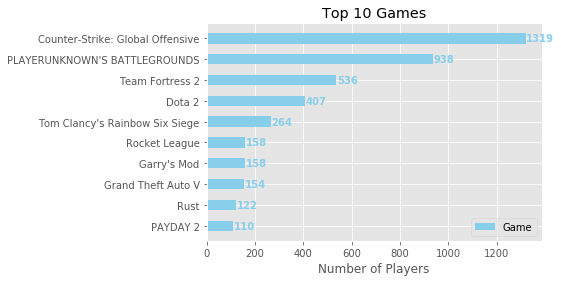

In [12]:
# Show the top 10 games and the number of player
# Count a valid point when this user has palyed a game for at least 2 hours.
app_id_name_mapping, app_id_user_mapping = load_games()
sorted_apps = sorted(app_id_user_mapping.items(), key=lambda x: len(x[1]), reverse=True)
top_app_players = list()
top_app_names = list()
for i in range(10):
    app = sorted_apps[i]
    top_app_players.append(len(app[1]))
    top_app_names.append(app_id_name_mapping[app[0]])
    
# Plot bar chart
barh_plot(top_app_players, 'Top 10 Games', 'Number of Players', top_app_names)

### Average playing time for each game

We also calculated and plotted the average time users spend on each game. The results show that users play Dota 2 spend longer time playing than other games although Dota 2 only rank 4th in the most played games. We think this result is reasonable since one Dota game last longer than compared with the top 3 games.

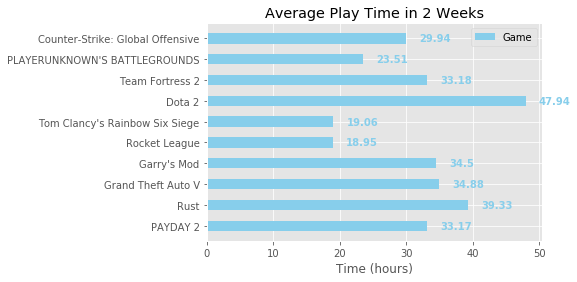

In [13]:
# Display the avg user playing time in the past 2 weeks
app_hour_list = list()
for i in range(10):
    app = sorted_apps[i]
    user_list = app[1]
    total_hours = 0
    for user in user_list:
        total_hours += user[1]
    app_hour_list.append(round(total_hours / len(user_list), 2))
barh_plot(app_hour_list, 'Average Play Time in 2 Weeks', 'Time (hours)', top_app_names)

### Playing time distribution for each game

The following code plots the cumulative density function of the playing time for each game. The y-axis stands for the cumulative density while x-axis is the log value of the playing time. Since there may be outliers in the data so we using the log value as the x-axis.

The shape of CDF for each game is pretty similar which means the distribution of user playing time for each game is similar. Games have a longer average playing time also have a relatively flat CDF curve like Dota 2.

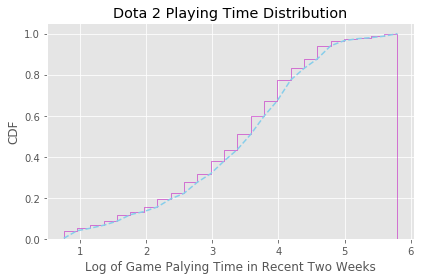

In [33]:
# Explore the playing time distribution for a game
import math
def time_distribution_hist(app_index, bin_num):
    app_id, user_list = sorted_apps[app_index]
    data = list()
    for user in user_list:
        data.append(math.log(user[1]))
    data = np.sort(data)
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(data, bin_num, density=True, histtype='step',
                               cumulative=True, label='Game', color='m')
    cdf_y = list()
    for value in bins:
        cdf_y.append(np.sum(data <= value) / data.shape[0])
    ax.plot(bins, cdf_y, 'k--', linewidth=1.5, label='Theoretical', color='SkyBlue')
    ax.set_xlabel('Log of Game Palying Time in Recent Two Weeks')
    ax.set_ylabel('CDF')
    ax.set_title(app_id_name_mapping[app_id] + ' Playing Time Distribution')
    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()
    
# Draw CDF of playing time of a game
time_distribution_hist(3, 25)

### Game playing behavior

Finally, we want to dig a little bit into the game playing behavior for steam users. So we counted the number of recently playing games for each steam user. From the plotting, we can conclude that one-third of the user only played one game in the recent two weeks. And the majority of the users won't play more than three games in the recent two weeks, which means most players focus their time on a few games. However, there are some master players that played 10 games (maybe more since the maximum number of games returned is set to 10).

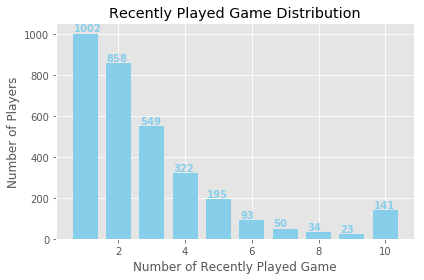

In [31]:
# Distribution of number of games, processing data
game_count_list = get_user_game_count()
game_count_dict = dict()
for count in game_count_list:
    if game_count_dict.get(count) is None:
        game_count_dict[count] = 0
    game_count_dict[count] += 1
data = list()
for i in range(1, 11):
    data.append(game_count_dict[i])
# Begin to draw the bar plot
fig, ax = plt.subplots()
rects = ax.bar(list(range(1, 11)), data, 0.75,color='SkyBlue', label='Game')
ax.set_xlabel('Number of Recently Played Game')
ax.set_ylabel('Number of Players')
ax.set_title('Recently Played Game Distribution')

for i, v in enumerate(data):
    ax.text(i + 1 - .35, v + 10, str(v), color='SkyBlue', fontweight='bold')
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

### Randomly Select 300 User to Visualize

Finally, we try to connect the user data we collected as a network and visualize it. We connect users if they have recently played the same games, and it turns out there will be a lot of edges in the graph and difficult to visualize. So we decide to randomly select 300 users from our dataset and plot the network between these users.

We use the igraph library to represent the user network, and use the plotly package to visualize this network. The package will export the graph into an HTML file.

In [36]:
# Select 300 random users
id_file_name = 'game_id_mapping.pkl'
mapping = read_mapping(id_file_name)
random_mapping_dict = dict()
overlapping_set = set()
counter = 300
while counter > 0:
    rand_key = random.choice(list(mapping.keys()))
    if rand_key in overlapping_set:
        continue
    overlapping_set.add(rand_key)
    random_mapping_dict[rand_key] = mapping[rand_key]
    counter -= 1

In [37]:
# Construct edges between these 300 users
# Load games first
app_id_name_mapping, app_id_user_mapping = load_games(random_mapping_dict)
# Construct edges
edges_dict, edges_game_dict = generate_edges(app_id_user_mapping)
point_list, edge_list, weight_list, edge_game_list = transfer_mapping(edges_dict, edges_game_dict, 1)
graph = generate_graph(point_list, edge_list, weight_list)

In [39]:
# Visualize the graph
layout = graph.layout('kk', dim=2)
point_num = len(point_list)
# Coordination of all points
Xn = [layout[i][0] for i in range(point_num)]
Yn = [layout[i][1] for i in range(point_num)]
# Coordination of all edges
Xe = list()
Ye = list()
for edge in edge_list:
    Xe += [layout[edge[0]][0], layout[edge[1]][0], None]
    Ye += [layout[edge[0]][1], layout[edge[1]][1], None]

trace_1 = Scatter(x=Xe, y=Ye, mode='lines', \
    line=Line(color='rgb(125,125,125)', width=1), hoverinfo='none',)

trace_2 = Scatter(x=Xn, y=Yn, mode='markers', \
    marker=Marker(symbol='dot', size=6, \
    colorscale='Viridis', line=Line(color='rgb(50,50,50)', width=0.5)), \
    text=list(range(point_num)), hoverinfo='text')


axis=dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title=''
            )

playout = Layout(
          title="Graph of 300 randomly selected players connected by their shared games",
          width=1000,
          height=1000,
          showlegend=False,
          scene=Scene(
          xaxis=XAxis(axis),
          yaxis=YAxis(axis),
          ),
      margin=Margin(
          t=100
      ),
      hovermode='closest',)


data = Data([trace_1, trace_2])
fig=Figure(data=data, layout=playout)
plotly.offline.plot(fig, filename='Community.html')

The generated user network looks like the following, and the graph also shows that most user just spend their time playing one game, and few users played more than one game recently.

![network](Player_Network.png)